In [110]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import cdist
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree


In [111]:
def generate_dataset(X,Y,
        x0,y0,R,
        error=0.3,drop_rate=0.1
        ):
    df=pd.DataFrame({'x':X,'y':Y})
    df_in_circle=df[(df['x']-x0)**2+(df['y']-y0)**2<R**2]
    df_in_circle.loc[:, 'x'] += np.random.uniform(-error, error, len(df_in_circle))
    df_in_circle.loc[:, 'y'] += np.random.uniform(-error, error, len(df_in_circle))
    df_in_circle=df_in_circle.sample(frac=1-drop_rate)
    return df_in_circle

def transform_dataset(x0,y0,theta,df_in_circle):
    # 平移df_in_circle到原点
    df_in_circle.loc[:, 'x'] -= x0
    df_in_circle.loc[:, 'y'] -= y0
    # 绕圆心旋转df_in_circle中的点theta角
    x_new=df_in_circle['x']*np.cos(theta)-df_in_circle['y']*np.sin(theta)
    y_new=df_in_circle['x']*np.sin(theta)+df_in_circle['y']*np.cos(theta)
    df_in_circle['x']=x_new
    df_in_circle['y']=y_new
    return df_in_circle


In [112]:
filename='axicon_pattern_crossflower.csv'
df = pd.read_csv(filename)
X=df['x']
Y=df['y']

x0,y0=np.random.uniform(-20,20,2)
measure_diameter=17
theta=np.random.uniform(0,2*np.pi)
theta=0

df_in_circle=generate_dataset(X,Y,x0,y0,measure_diameter/2,error=0.1)
df_in_circle=transform_dataset(x0,y0,theta,df_in_circle)
df_in_circle.to_csv('axicon_pattern_crossflower_measure.csv',index=False)

data_measured=df_in_circle
data_original=df

df_original=df 
df_measured=df_in_circle

points_original = df_original[['x', 'y']].values
points_transformed = df_measured[['x', 'y']].values

In [113]:
import numpy as np
from scipy.spatial import KDTree

def icp(data_original, data_measured, iterations=10000, tolerance=1e-6):
    R = np.eye(2)  # 初始化为单位矩阵
    t = np.zeros(2)  # 初始化为零向量

    last_error = float('inf')

    for i in range(iterations):
        tree = KDTree(data_original)
        distances, indices = tree.query(data_measured)
        matched_points = data_original[indices]

        # 计算中心点
        centroid_original = np.mean(matched_points, axis=0)
        centroid_measured = np.mean(data_measured, axis=0)

        # 去中心化
        centered_original = matched_points - centroid_original
        centered_measured = data_measured - centroid_measured

        # SVD 分解来计算最佳旋转
        U, _, Vt = np.linalg.svd(centered_measured.T @ centered_original)
        R_temp = Vt.T @ U.T

        # 保证是正交旋转
        if np.linalg.det(R_temp) < 0:
            Vt[1, :] *= -1
            R_temp = Vt.T @ U.T

        t_temp = centroid_original - R_temp @ centroid_measured

        # 更新数据集
        data_measured = (R_temp @ data_measured.T).T + t_temp

        # 计算误差
        current_error = np.mean(distances)
        if np.abs(last_error - current_error) < tolerance:
            print(f"Converged at iteration {i}")
            break
        last_error = current_error

        # 更新累积的旋转矩阵和平移向量
        R = R_temp @ R
        t = R_temp @ t + t_temp

    return R, t, data_measured

# 使用示例
R, t, transformed_data = icp(data_original.to_numpy(), data_measured.to_numpy())


Converged at iteration 8


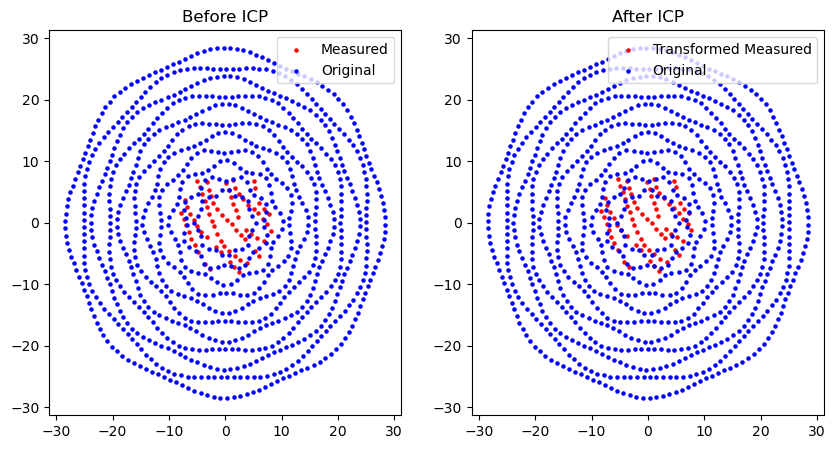

Estimated Rotation Matrix:
 [[ 0.9998857   0.01511881]
 [-0.01511881  0.9998857 ]]
Estimated Translation Vector:
 [-0.46456487  0.19594245]


In [114]:

# 可视化结果
def plot_points(A, B, transformed_A):
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.title('Before ICP')
    plt.scatter(A[:, 0], A[:, 1], c='red', label='Measured',s=5)
    plt.scatter(B[:, 0], B[:, 1], c='blue', label='Original',s=5)
    plt.legend()

    plt.subplot(122)
    plt.title('After ICP')
    plt.scatter(transformed_A[:, 0], transformed_A[:, 1], c='red', label='Transformed Measured',s=5)
    plt.scatter(B[:, 0], B[:, 1], c='blue', label='Original',s=5)
    plt.legend()
    plt.show()

transformed_measured = points_transformed @ R.T + t
plot_points(points_transformed, points_original, transformed_measured)

print("Estimated Rotation Matrix:\n", R)
print("Estimated Translation Vector:\n", t)
